## Introduction:

Main Goals:

1. Identify the recipients that will engage with the campaign.
2. Maximise the campaign’s revenue.


Comments

- The dataset contains only 5% of donors.
- The donations are usually smaller than $20.
- This data is quite noisy, high dimensional.
- There is an inverse relationship between the probability to donate and the amount donated.


Link for dataset and some analysis ==> 

https://github.com/rebordao/kdd98cup

https://github.com/bobbyantonio/KDD98/blob/master/CleanData.py

- Github solutions ==>
https://github.com/rebordao/kdd98cup


- Siraj notebook for a better data visualization:

https://www.youtube.com/watch?v=yQsOFWqpjkE

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import rnn, rnn_cell
from sklearn.model_selection import train_test_split
import pandas as pd
import random

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline


import csv
import sys

# import datetime as dt

## warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset:

In [2]:
def load_data():
    list_of_lists = []

    ## works correctly but takes too much running time ..
    with open('cup98LRN.txt', 'r') as f:# open the file for reading
        df = []
        for row_num, line in enumerate(f):
            # Remove the new line at the end and then split the string based on
            # tabs. This creates a python list of the values.
            values = line.strip().split(',')
            if row_num == 0: # first line is the header
                 header = values
            else:
                df.append([v for v in values])

        df = pd.DataFrame(df)
        df.columns = header
        df.drop(df.index[0], inplace=True)
        
        df = df[0:1000]  ## to save time .. I gonna work on only 100 records ..
        
        return df

In [3]:
## I have to run it over all the data not just 100 records
df = load_data()
df.head(3)

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
1,9401,BOA,1,CA,91326,,,5202,0,,...,0,0,L,2,G,X,X,X,1,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0,1,L,4,E,X,X,X,60,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0,1,L,4,E,X,X,X,41,C


Only ADATE is valid .. 

RFA ==> only 3 characters not 4

RAMNT_3, RDATE ==> are empty ! ..

Continous actions .. 

Let's assume that ADATE represents the continous actions variable (i.e. the number of the month gifts have been sent in) ..

RDATE represents the discrete variable .. action taken (i.e. action # 2, # 3 .. and null values will be replaced by 0, to reprsent no action)

In [4]:
# discrete + continuous actions 
def actions_prep(df):
    
    date_data = ['ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 
                'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15',
                'ADATE_16', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_12',
                'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8', 
                'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15',
                'RDATE_16', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_12',
                'RDATE_22', 'RDATE_23', 'RDATE_24']
    t = []
    temp = np.transpose(df[date_data])

    for j in xrange(len(temp)):
        for i in xrange(np.shape(df)[0]):
             t.append(temp.iloc[j].iloc[i][2:])

    actions = np.reshape(t, [46, np.shape(df[date_data])[0]])
    actions = pd.DataFrame(np.transpose(actions))
   
    actions = actions.replace('', 0)
    
    return actions

Mapping .. to inforce max action to be 11  

                              2: 'NK',  3: 'NK',
                              4: 'TK',  5: 'SK',
                              6: 'LL',  7: 'G1',
                              8: 'GK',  9: 'CC',
                              10: 'WL', 11: 'X1',
                              12: 'XK', 13: 'FS',
                              14: 'NK', 15: 'TK',
                              16: 'LL', 17: 'G1',
                              18: 'GK', 19: 'CC',
                              20: 'WL', 21: 'X1',
                              22: 'XK', 23: 'FS', 24: 'NK'

## Data Preprocessing:

1. Gets some redundant variables .. by calculating the correlation between all the variables .. 
those of high correlation coeffecient are redundant .. 

__NOTE:__
In this implementation .. 

https://github.com/EAboelhamd/kdd98cup/blob/master/donors.py

They tried to figure out redundant variables to remove them .. to be able to decrease the dimentionality of the problem .. however, in my case, there is no need to do .. as I'm gonna implement deep learning not a shallow solution .. 

In [5]:
def data_preperation():
    df = load_data()
    
    df = df[df.columns.difference(['TARGET_B'])]
    
    actions = actions_prep(df)
    
    data = ['RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
            'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22','RFA_23','RFA_24'
            ,'RAMNT_3', 'RAMNT_4','RAMNT_5','RAMNT_6', 'RAMNT_7','RAMNT_8','RAMNT_9', 'RAMNT_10',
          'RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20'
          ,'RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24']
    
    
    for i in xrange(len(data)):
        df[data[i]] = pd.Categorical((pd.factorize(df[data[i]])[0] + 1).astype(str))
    
    rewards = ['TARGET_D']
    
    df_data_1 = pd.merge(df[data], df[rewards], left_index = True, right_index = True)
    df_data = pd.merge(df_data_1, actions, left_index=True, right_index=True)
    
    return df_data

In [6]:
def df_split():  
    df_data = data_preperation()
    train, test = train_test_split(df_data, test_size = 0.5)  # split data to 50-50 cross validate 
    
    return train, test

In [7]:
train, test = df_split()
test = test.drop(test.index[len(test)-1]) ## exclude last row in test to have same number of rows as train 

## prepare train, test
rewards = ['TARGET_D']
x_train = train[train.columns.difference(['TARGET_D'])]
y_train = train[rewards]

x_test = test[test.columns.difference(['TARGET_D'])]
y_test = test[rewards]

In [8]:
train.head()

,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,...,36,37,38,39,40,41,42,43,44,45
124,10,14,14,15,5,1,1,9,2,29,...,0,0,0,0,0,0,10,0,0,0
947,7,24,24,18,59,51,53,52,11,14,...,0,0,0,0,0,0,12,0,0,0
895,8,10,10,9,10,23,19,18,21,25,...,0,0,0,0,0,0,0,0,0,0
341,5,5,5,5,5,1,1,30,24,29,...,0,0,0,0,01,0,09,0,0,0
21,8,12,12,5,15,18,18,9,2,17,...,0,0,0,06,0,0,0,0,0,0


## Current State variables ..
Recency, Frequancy, Montery variables .. ['RFA_2R', 'RFA_2F', 'RFA_2A']

## Rewards:
- Donation amount 
- These are the target variables as well .. 
- TARGET_D, TARGET_B 


## Actions: 
- 11 mailing type

Actions mapping .. 
https://github.com/EAboelhamd/kdd98-1/tree/master/notebooks

## Actions:

- mailing types ..
action_mapping = {

                                    2: 'NK',  3: 'NK',
                                    4: 'TK',  5: 'SK',
                                    6: 'LL',  7: 'G1',
                                    8: 'GK',  9: 'CC',
                                    10: 'WL', 11: 'X1',
                                    12: 'XK', 13: 'FS',
                                    14: 'NK', 15: 'TK',
                                    16: 'LL', 17: 'G1',
                                    18: 'GK', 19: 'CC',
                                    20: 'WL', 21: 'X1',
                                    22: 'XK', 23: 'FS', 24: 'NK'
                                }

this list contains 11 unique values (NK, TK,LL,GK,WL,XK,SK,G1,CC,X1,FS)

                                        NK ==> 2, 14, 23, 24
                                        LL ==> 2, 16
                                        TK ==> 4, 15
                                        GK ==> 8, 18
                                        WL ==> 10, 20
                                        SK ==> 5
                                        G1 ==> 7, 17
                                        CC ==> 9, 19
                                        X1 ==> 11, 21
                                        FS ==> 13, 23

Their corresponding meanings are:

                                        LL mailings had labels only                                        
                                        WL mailings had labels only
                                        CC mailings are calendars with stickers but do
                                           not have labels
                                        FS mailings are blank cards that fold into
                                           thirds with labels
                                        NK mailings are blank cards with labels
                                        SK mailings are blank cards with labels
                                        TK mailings have thank you printed on the
                                           outside with labels
                                        GK mailings are general greeting cards (an
                                           assortment of birthday, sympathy, blank, & get
                                           well) with labels
                                        XK mailings are Christmas cards with labels
                                        X1 mailings have labels and a notepad
                                        G1 mailings have labels and a notepad

- This is why I'm gonna extract the last two digits from the sequance to represent mailing type (unique values are 11 .. NK, TK, SK, LL, G1, GK, CC, WL, X1, XK, FS) + no action .. total action are 12

## States:

In the cited paper .. they defined the states as follows: 

It is a 5-dimensional vector consisting of 

(1) how recently the donor donated last (R)

(2) how frequently she donates (F)

(3) her average donation amount (M)

(4) how many times PVA sends her a mail in the last six months

(5) how many times PVA has sent her mails.


This implementation is considered as a POMPD .. 
where:
b: belief state that is a probability distribution over all states
b(s): prob. that the agent in state s 
after taking action a and observing the state O .. the update rule for the belief state o(s) is using Bayes rule .. 

## Next States:

As mentioned in the paper ==> the 5-dimensional observation is discrete in this problem, and individual dimensions evolve
independently of each other. We therefore build an observation probability table for each observation dimension,
and the sample next observations using these tables.

Hence, Let's create an n*5 dim observations table .. 

http://www-anw.cs.umass.edu/~barto/courses/cs687/PartialObs-printable.pdf


### These researchers proposed other types of state space ==>

https://www.cs.cmu.edu/~ebrun/15889e/hw1.pdf

as 9 vars (try it out) ;) .. 
and others consider (belief, observation)

In [9]:
def tuple_(actions):
    
    train, test = df_split()
    
    RFA = ['RFA_2']  # don't know if it is NUMPRM12 or CARDPM12 

    ## next state
    ## next_states are random selection from the current states
    RFA_next = ['RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10',
                'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18',
                'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24']

    current_states = train['RFA_2']
    next_states = train[RFA_next]
    
    rewards = ['TARGET_D']
     
    next_actions = np.zeros([len(next_states), 12])
    
    
    #     # fill in next_actions  
    for i in xrange(np.shape(next_actions)[1]):
        next_actions[:, i] = i
        
#     next_actions = pd.DataFrame(next_actions)
    
    tuplesMx = np.column_stack((current_states, actions, next_states, next_actions, train[rewards]))

    return tuplesMx #, train[rewards] #next_states, next_actions, curr_state_current_action

In [10]:
actions = actions_prep(df)
tuplesMx = tuple_(actions[:499])
# np.shape(tuplesMx)

In [11]:
y_outputs = tuplesMx[:,-1]
x_inputs = tuplesMx[:,:-1]
# x_inputs

## Regression phase:

Before performing the prediction task .. let's split the data to training and validation sets .. 

To avoid any problems in prediction by having string variables .. let's binarize (catergorize) all the variables .. 

Guidance ==> https://pythonprogramming.net/rnn-tensorflow-python-machine-learning-tutorial/

In [12]:
gamma = 0.9
Num_itrs = 2  # no loop 3leha ( w dah el sa7) .. we just have to run the whole algo. 10 times and report the avg. results

# num_epoch = 1 #23 #epochs are cycles of Feedforward and Backprob
## el mafrood yeb2a feh loop 3la el epochs elli heyya el steps .. w avg. reward per step is calculated 
batch_size = 200 #np.shape(x_train)[0]
# chunkSize = 1

n_nodes_hl1 = 40 #np.shape(x_train)[1]
n_nodes_hl2 = 15 #np.shape(actions)[1]
# NUM_STATES = np.shape(x_train)[1]
NUM_DIM = 82 #batch_size   #np.shape(tuplesMx)[1]
# num_nodes = np.shape(x_train)[0]
# num_unrollings = 5
    
best_actions = np.zeros([np.shape(x_train)[0], 1])
Q_optimal = [] #np.zeros([np.shape(curr_state_current_action)[0], len(df['ACCOUNT_STATUS'].unique())])

## Multilayer Deep Neural Network (DQN):

https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5_Deep_Q_Network/RL_brain.py

## Model Training:

https://stackoverflow.com/questions/46832151/tensorflow-neural-network-multi-layer-perceptron-for-regression-example

Guidance: https://www.youtube.com/watch?v=FbJw8J0rTyQ

In [13]:
def DQN_train(x_inputs, y_outputs):
    
    ######################## set learning variables ##################
    
    learning_rate = 0.001  #Learning rate controls how much to change the weight to correct for the error. 
    epochs = 100
    
    ######################## set some variables #######################
    x = tf.placeholder(tf.float32)  # 3 features  # , [None, NUM_DIM], name='x'
    y = tf.placeholder(tf.float32)  # 3 outputs   # , [None, 1], name='y'

    
    # hidden layer 1
    W1 = tf.Variable(tf.random_uniform([NUM_DIM, n_nodes_hl1],0, 3), name='W1')
    b1 = tf.Variable(tf.random_uniform([n_nodes_hl1],0,3), name='b1')

    # hidden layer 2
    W2 = tf.Variable(tf.random_uniform([n_nodes_hl1, n_nodes_hl2],0,3), name='W2')
    b2 = tf.Variable(tf.random_uniform([n_nodes_hl2],0,3), name='b2')

    ######################## Activations, outputs ######################
    # output hidden layer 1
    hidden_out = tf.nn.relu(tf.add(tf.matmul(x, W1), b1))

#     total output
    y_ = tf.nn.relu(tf.add(tf.matmul(hidden_out, W2), b2))
    
    
    ####################### Loss Function  #########################
    mse = tf.losses.mean_squared_error(y, y_)

    ## I can try Adam optimizer ==> = GD Momentum + RMSProb 
    ####################### Optimizer ######################### read more about RMSProb: https://www.youtube.com/watch?v=_e-LFe_igno
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=0.99).minimize(mse)  # optimizer like Gredient Descent 

    ###################### Initialize, Accuracy and Run #################
    # initialize variables
    init_op = tf.global_variables_initializer()

    # accuracy for the test set
    accuracy = tf.reduce_mean(tf.square(tf.subtract(y, y_)))  # or could use tf.losses.mean_squared_error

    loss_RNN = []
    
    avg_ = []
    
    
    with tf.Session() as sess:
        sess.run(init_op)
        total_batch = int(len(y_outputs) / batch_size)
        
        for epoch in range(epochs):
            avg_cost = 0
            
            for i in range(total_batch):
                batch_x, batch_y = x_inputs[i * batch_size:min(i * batch_size + batch_size, len(x_inputs))], \
                             y_outputs[i * batch_size:min(i * batch_size + batch_size, len(y_outputs))]
                
#                 print batch_y[0]
                
                predicted_output = sess.run(y_[0], feed_dict={x: batch_x, y: batch_y[0]})
                
                _, c = sess.run([optimizer, mse], feed_dict={x: batch_x, y: batch_y[0]})

                avg_cost += c / total_batch          
            
            if epoch % 100 == 0:
                avg_.append(avg_cost)
                plt.plot(avg_)
                plt.xlabel('Step Number')
                plt.ylabel('Prediction Loss')
                
        return predicted_output.astype(np.int32)

Q(s,a) representing the (Quality) of action a at state is .. 

this Q value depends on the immediate reward r .. however, it'll be more effective if it takes the future rewards Q(s', a') into consideration .. 

the future rewards are discounted by probability gama .. cause the evironment is stochastic hence, it is uncertain that each time you select action a you gonna get the same reward r

In [17]:
# # predicted_reward = np.transpose(predicted_reward) 
def Q_learning():
    
    avg_Q = []    
    Q_predicted = np.zeros([np.shape(x_inputs)[0], 12])
    best_action = list() #np.zeros([np.shape(train)[0], batch_size])
    
    
    actions = actions_prep(df)
    nepisod =  np.shape(actions)[1]  ##22+
    
    for i in xrange(nepisod):
        tuplesMx = tuple_(actions[:499])  # nepisod ==> 46, tuplesMx[:,-1] ==> 499
        
        Q_optimal = tuplesMx[:,-1].astype(np.float32) + gamma*np.max(Q_predicted) # returns max value per row !
        
        Q_predicted = DQN_train(tuplesMx, Q_optimal)
        
        
        best_action.append(np.argmax(Q_predicted, axis=0))
   
#         try:
#             best_action.append(np.argmax(Q_predicted, axis=0))
            
#         except ValueError:
#             print "Error"
#             continue
    
    return best_action

Tensor("Relu_5:0", shape=(?, 15), dtype=float32)
Tensor("Relu_7:0", shape=(?, 15), dtype=float32)
Tensor("Relu_9:0", shape=(?, 15), dtype=float32)
Tensor("Relu_11:0", shape=(?, 15), dtype=float32)
Tensor("Relu_13:0", shape=(?, 15), dtype=float32)
Tensor("Relu_15:0", shape=(?, 15), dtype=float32)
Tensor("Relu_17:0", shape=(?, 15), dtype=float32)
Tensor("Relu_19:0", shape=(?, 15), dtype=float32)
Tensor("Relu_21:0", shape=(?, 15), dtype=float32)
Tensor("Relu_23:0", shape=(?, 15), dtype=float32)
Tensor("Relu_25:0", shape=(?, 15), dtype=float32)
Tensor("Relu_27:0", shape=(?, 15), dtype=float32)
Tensor("Relu_29:0", shape=(?, 15), dtype=float32)
Tensor("Relu_31:0", shape=(?, 15), dtype=float32)
Tensor("Relu_33:0", shape=(?, 15), dtype=float32)
Tensor("Relu_35:0", shape=(?, 15), dtype=float32)
Tensor("Relu_37:0", shape=(?, 15), dtype=float32)
Tensor("Relu_39:0", shape=(?, 15), dtype=float32)
Tensor("Relu_41:0", shape=(?, 15), dtype=float32)
Tensor("Relu_43:0", shape=(?, 15), dtype=float32)
Ten

[4,
 3,
 0,
 6,
 2,
 4,
 14,
 8,
 10,
 7,
 9,
 5,
 5,
 1,
 10,
 5,
 9,
 1,
 1,
 3,
 13,
 3,
 8,
 10,
 5,
 4,
 14,
 13,
 9,
 5,
 11,
 3,
 1,
 6,
 13,
 11,
 9,
 11,
 2,
 3,
 7,
 7,
 14,
 2,
 8,
 0]

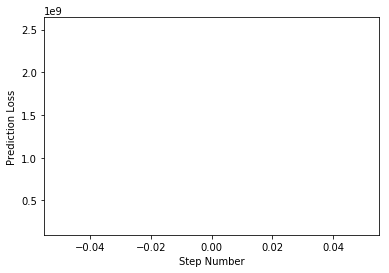

In [18]:
best_action = Q_learning()
best_action